In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (16, 9)

In [2]:
import pqr

# Загрузка и предобработка данных

In [3]:
prices = pd.read_excel('factors/russia/monthlyprice.xlsx', index_col=0, parse_dates=True)
mcap = pd.read_excel('factors/russia/mcap.xlsx', index_col=0, parse_dates=True)
volume = pd.read_excel('factors/russia/betafilter.xlsx', index_col=0, parse_dates=True)
imoex = pd.read_excel('factors/russia/imoex.xlsx', index_col=0, parse_dates=True)

prices, mcap, volume, imoex = pqr.utils.replace_with_nan(prices, mcap, volume, imoex)

# Настраиваем окружение - Юниверс, Бенчмарк и факторы

In [4]:
universe = pqr.Universe(prices)
universe.filter(volume >= 10_000_000)

preprocessor = [
    pqr.Filter(universe.mask),
    pqr.LookBackMean(3),
    pqr.Hold(3),
]

size = pqr.Factor(mcap, better="less", preprocessor=preprocessor)

benchmark = pqr.Benchmark.from_index(imoex["IMOEX"], name="IMOEX")

# 1 способ использования: строим факторную модель

Данный способ хорошо подходит для первичного анализа фактора и научных исследований наличия факторов на том или ином рынке.

Сначала построим одну модель с параметрами 3-0-3

In [5]:
fm = pqr.fm.FactorModel(
    picking_strategies=[
        pqr.fm.Quantiles(0, 1/3),
        pqr.fm.Quantiles(1/3, 2/3),
        pqr.fm.Quantiles(2/3, 1),
    ],
    allocation_strategy=pqr.EqualWeights(),
    add_wml=True
)

portfolios = fm(size, universe)

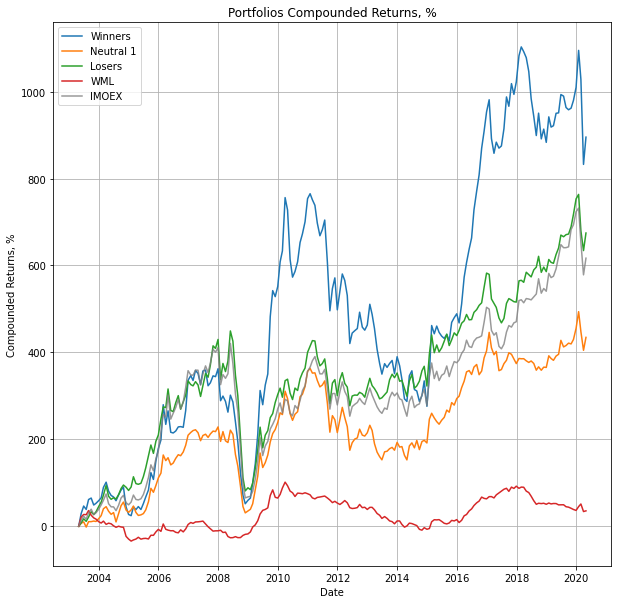

,Winners,Neutral 1,Losers,WML
"Mean Return, %",1.54,1.08,1.25,0.29
"Volatility, %",9.25,7.18,6.88,5.47
Sharpe Ratio,0.58,0.52,0.63,0.19
"Mean Excess Return, %",3.84,-1.73,0.30,-11.13
"Alpha, %",2.20,-0.02,1.23,0.98
Beta,1.11,0.88,0.94,0.17


In [6]:
summary = pqr.dash.Dashboard(
    pqr.dash.Graph(pqr.metrics.CompoundedReturns(), benchmark=benchmark),
    pqr.dash.Table(
        pqr.metrics.MeanReturn(annualizer=1),
        pqr.metrics.Volatility(annualizer=1),
        pqr.metrics.SharpeRatio(rf=0),
        pqr.metrics.MeanExcessReturn(benchmark),
        pqr.metrics.Alpha(benchmark),
        pqr.metrics.Beta(benchmark),
    )
)
summary(portfolios)

## Поищем модель получше

Результаты получились не очень: ни один портфель не победил бенчмарк. Скорее всего, параметры подобраны неправильно, но вручную перебирать их может быть довольно-таки трудозатратно. К тому же, есть риск пропустить хорошую модель.

Поэтому воспользуемся перебором параметров.

In [7]:
def preprocessor_mean_factory(looking, lag, holding):
    return [
        pqr.Filter(universe.mask),
        pqr.LookBackMean(looking),
        pqr.Lag(lag),
        pqr.Hold(holding)
    ]


param_grid = {
    "(1, 0, 1)": preprocessor_mean_factory(1, 0, 1),
    "(1, 1, 1)": preprocessor_mean_factory(1, 1, 1),
    "(3, 0, 3)": preprocessor_mean_factory(3, 0, 3),
    "(3, 1, 3)": preprocessor_mean_factory(3, 1, 3),
    "(6, 0, 6)": preprocessor_mean_factory(6, 0, 6),
    "(6, 1, 6)": preprocessor_mean_factory(6, 1, 6),
    "(9, 0, 9)": preprocessor_mean_factory(9, 0, 9),
    "(9, 1, 9)": preprocessor_mean_factory(9, 1, 9),
    "(12, 0, 12)": preprocessor_mean_factory(12, 0, 12),
    "(12, 1, 12)": preprocessor_mean_factory(12, 1, 12),
}

gs = pqr.fm.GridSearch(
    factor_preprocessors=param_grid,
    factor_model=fm
)

size_raw = pqr.Factor(mcap, better="less")

results = gs(
    factor=size_raw,
    universe=universe,
    target=pqr.metrics.Alpha(benchmark)
)

In [8]:
results

,Winners,Neutral 1,Losers,WML
"(1, 0, 1)",-0.024707,0.052993,0.010092,-0.034799
"(1, 1, 1)",-0.003618,0.040185,0.021788,-0.025405
"(3, 0, 3)",0.022023,-0.000249,0.012256,0.009766
"(3, 1, 3)",0.014447,0.002088,0.005294,0.009153
"(6, 0, 6)",-0.046546,0.056485,0.027560,-0.074106
"(6, 1, 6)",-0.060402,0.040996,0.019284,-0.079686
"(9, 0, 9)",-0.002082,0.050505,0.025958,-0.028040
"(9, 1, 9)",-0.020717,0.051999,0.014195,-0.034912
"(12, 0, 12)",-0.030925,0.057711,0.001749,-0.032674
"(12, 1, 12)",-0.034159,0.055180,0.000573,-0.034732


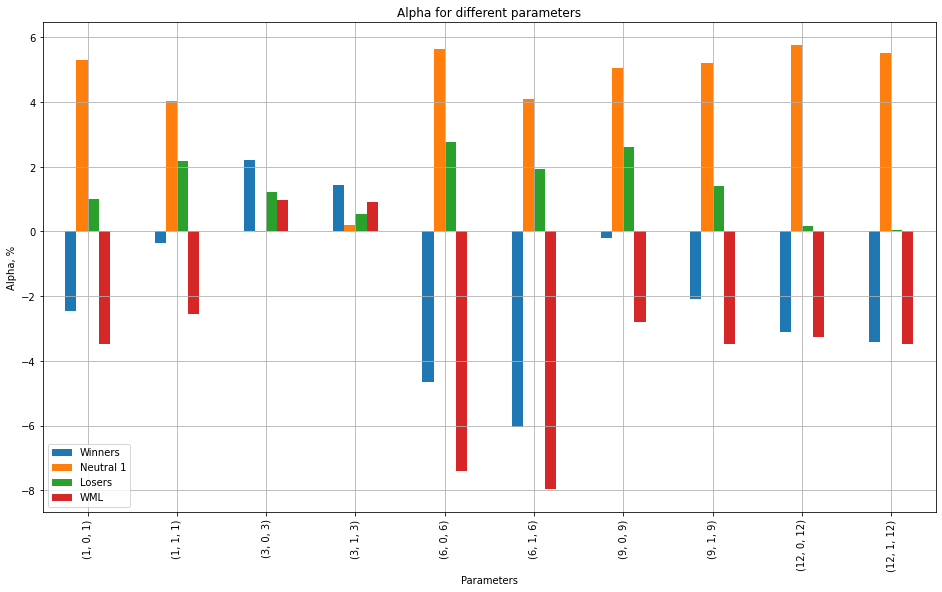

In [9]:
(results * 100).plot.bar()
plt.title("Alpha for different parameters")
plt.xlabel("Parameters")
plt.ylabel("Alpha, %")
plt.grid();

Видно, что лучшая модель с точки зрения WML имеет параметры (3, 1, 3), но лучший портфель - нейтральный с параметрами 12, 0, 12. Его и протестируем.

In [10]:
size_best = pqr.Factor(mcap, "less", param_grid["(12, 0, 12)"])
portfolios = fm(size_best, universe)

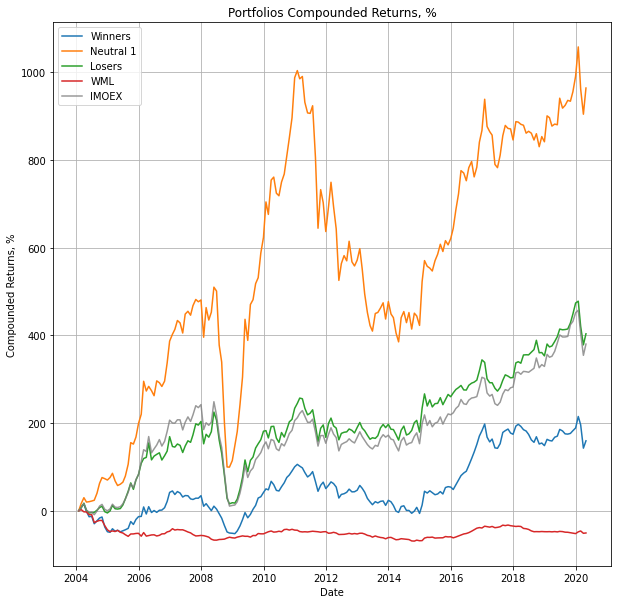

,Winners,Neutral 1,Losers,WML
"Mean Return, %",0.88,1.54,1.09,-0.22
"Volatility, %",8.83,8.02,7.20,5.32
Sharpe Ratio,0.34,0.67,0.52,-0.14
"Mean Excess Return, %",-2.18,5.79,0.40,-15.28
"Alpha, %",-2.69,6.14,0.55,-3.24
Beta,1.04,0.97,0.99,0.05


In [11]:
summary(portfolios)

### Лучший портфель поподробнее

Шарп получился меньше 1, не очень впечатляет, но посмотрим поподробнее на данный портфель. После обучения модели все портфели сохраняются в список, нас интересует 2 элемент.

In [12]:
best_portfolio = portfolios[1]

Посмотрим на изменение годовой беты портфеля: видно, что в основном бета колеблется около 1, но в последние годы снизилась почти наполовину, при этом был скачок до более чем 1.6 в 2013 году

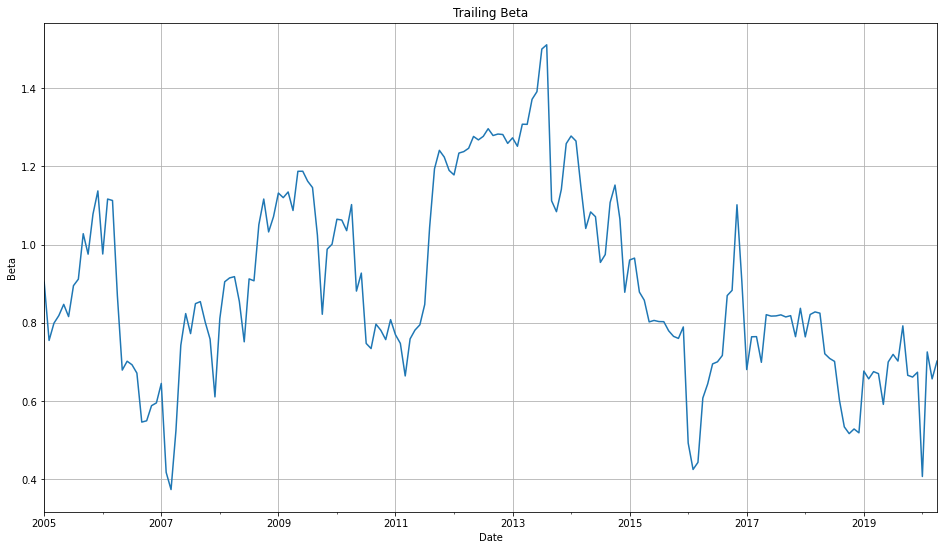

In [13]:
pqr.metrics.TrailingBeta(benchmark)(best_portfolio).plot()

plt.title("Trailing Beta")
plt.xlabel("Date")
plt.ylabel("Beta")
plt.grid();

Годовой Шарп выглядит совсем непривлекательно - американские горки, но в некоторые моменты он доходил до 3.

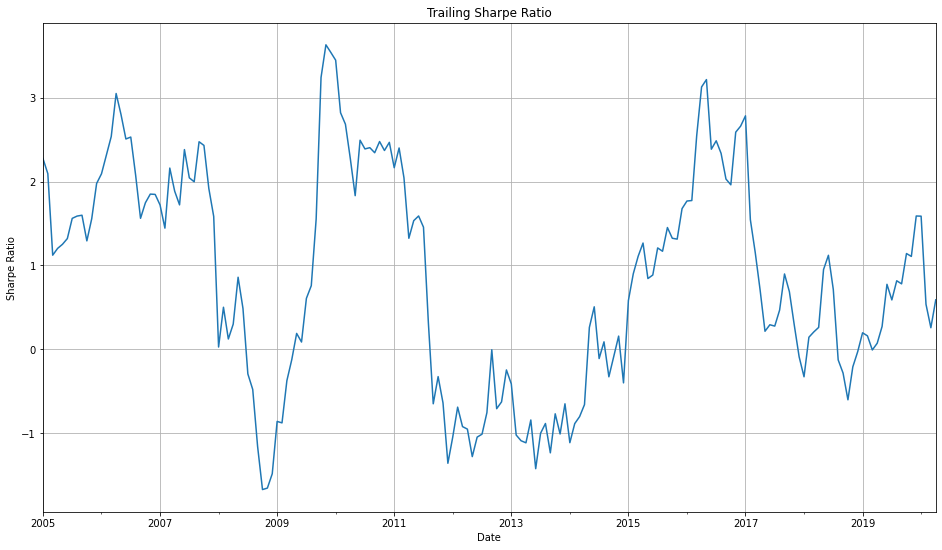

In [14]:
pqr.metrics.TrailingSharpeRatio()(best_portfolio).plot()

plt.title("Trailing Sharpe Ratio")
plt.xlabel("Date")
plt.ylabel("Sharpe Ratio")
plt.grid();

Годовая просадка в целом не так ужасно выглядит, но в 2008 падение стоило бы почти всего портфеля, а в 2013-2014 была бы потеряна половина доходности портфеля.

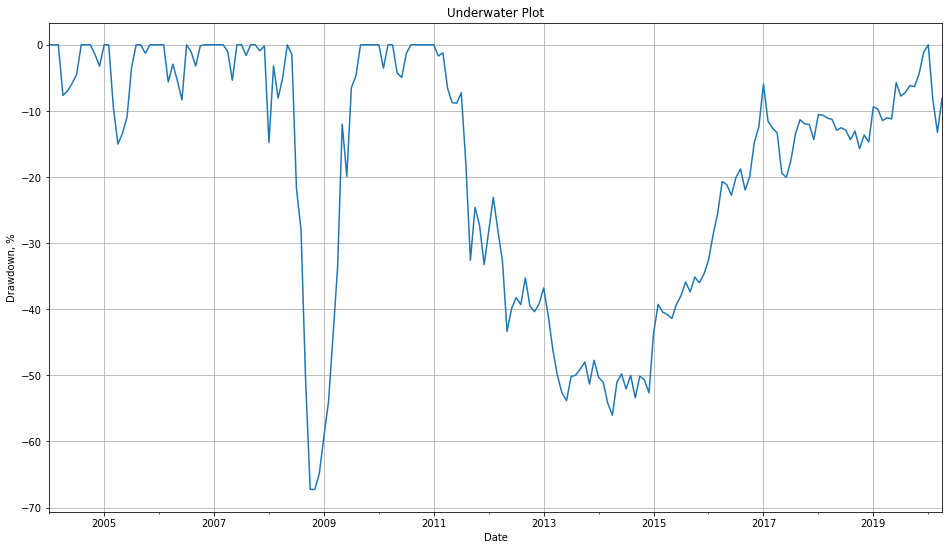

In [15]:
(pqr.metrics.Drawdown()(best_portfolio) * 100).plot()

plt.title("Underwater Plot")
plt.xlabel("Date")
plt.ylabel("Drawdown, %")
plt.grid();

# 2 способ использования: строим и настраиваем портфель

В примере выше мы хотели рассмотреть всего 1 портфель, для этого нам не было необходимости строить еще 2 дополнительных. Но данная глава нужна не только для того, чтобы облегчить расчеты, иногда нас может интересовать конкретный портфель, и мы хотим сконцентрироваться на его настройке. Ну или требуется более подробно изучить фактор.

Но для этого придется чуть больше погрузиться в библиотеку.

In [16]:
# создадим 2 стратегии отбора акций: топ-10 акций по фактору и топ 10% акций по фактору
top10 = pqr.fm.Top(10)
q01 = pqr.fm.Quantiles(0, 0.1)

# проинвестируем в оба в нашу изначальную стратегию 3-0-3
top10_portfolio = pqr.Portfolio(
    universe,
    longs=top10(size),
    allocation_strategy=pqr.EqualWeights(),
    name="Top 10"
)


q01_portfolio = pqr.Portfolio(
    universe,
    longs=q01(size),
    allocation_strategy=pqr.EqualWeights(),
    name="Top 10%"
)

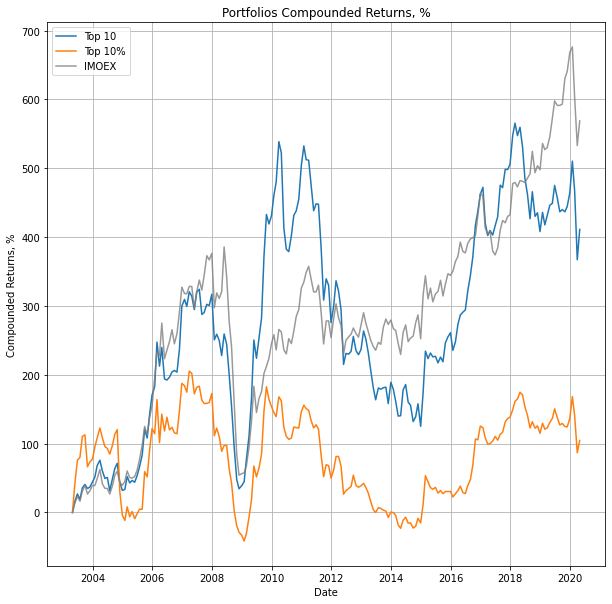

,Top 10,Top 10%
"Mean Return, %",1.18,1.07
"Volatility, %",8.82,12.24
Sharpe Ratio,0.46,0.30
"Mean Excess Return, %",-0.07,-1.41
"Alpha, %",-0.93,-5.61
Beta,1.06,1.29


In [17]:
summary([top10_portfolio, q01_portfolio])

Окей, возьмем в разработку портфель из топ-10 компаний по капитализации. Попробуем взвесить его по ней же, получится по сути своей смарт-бета портфель (за тем лишь исключением, что фактор размера мы используем в другую сторону:)).

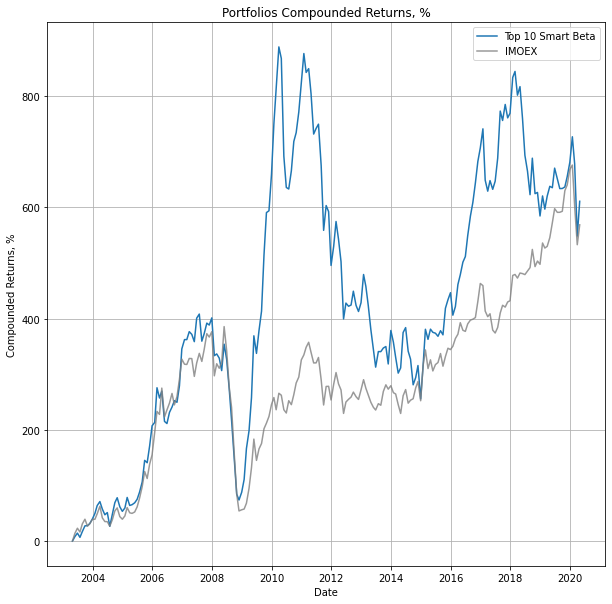

,Top 10 Smart Beta
"Mean Return, %",1.31
"Volatility, %",8.41
Sharpe Ratio,0.54
"Mean Excess Return, %",1.51
"Alpha, %",1.94
Beta,0.97


In [18]:
top10_portfolio_smart_beta = pqr.Portfolio(
    universe,
    longs=top10(size),
    allocation_strategy=pqr.WeightsByFactor(size),
    name="Top 10 Smart Beta"
)

summary([top10_portfolio_smart_beta])

Стало лучше, но все равно даже не догоняем бенчмарк. Попробуем применить обратный подход для взвешивания

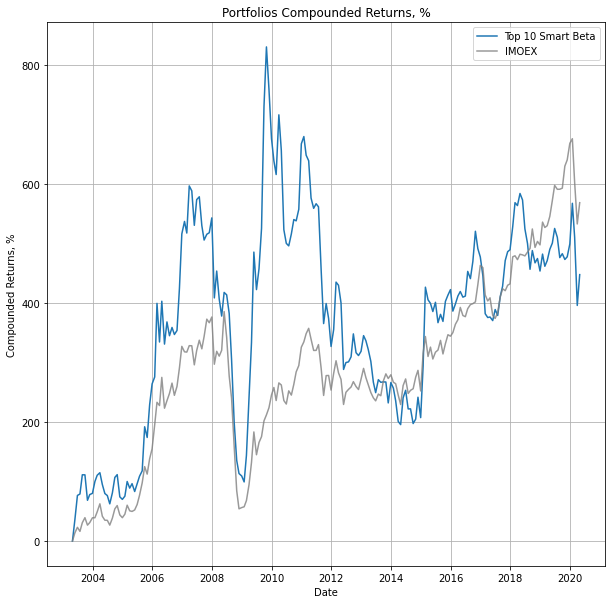

,Top 10 Smart Beta
"Mean Return, %",1.39
"Volatility, %",10.87
Sharpe Ratio,0.44
"Mean Excess Return, %",2.42
"Alpha, %",-0.53
Beta,1.21


In [19]:
size_reversed = pqr.Factor(1 / mcap, "less", preprocessor)

top10_portfolio_smart_beta_reversed = pqr.Portfolio(
    universe,
    longs=top10(size),
    allocation_strategy=pqr.WeightsByFactor(size_reversed),
    name="Top 10 Smart Beta"
)

summary([top10_portfolio_smart_beta_reversed])

Отставание от бенчмарка увеличилось, при этом волатильность портфеля также сильно возросла. Грааль не найден :(

# Случайный тест

In [20]:
%%time
%%capture

zi = pqr.tests.ZeroIntelligenceTest(
    universe,
    pqr.EqualWeights(),
    pqr.metrics.TrailingMeanReturn(),
    n=1000
)

zi_est = zi(best_portfolio)

CPU times: user 9.31 s, sys: 2.86 ms, total: 9.31 s
Wall time: 9.31 s


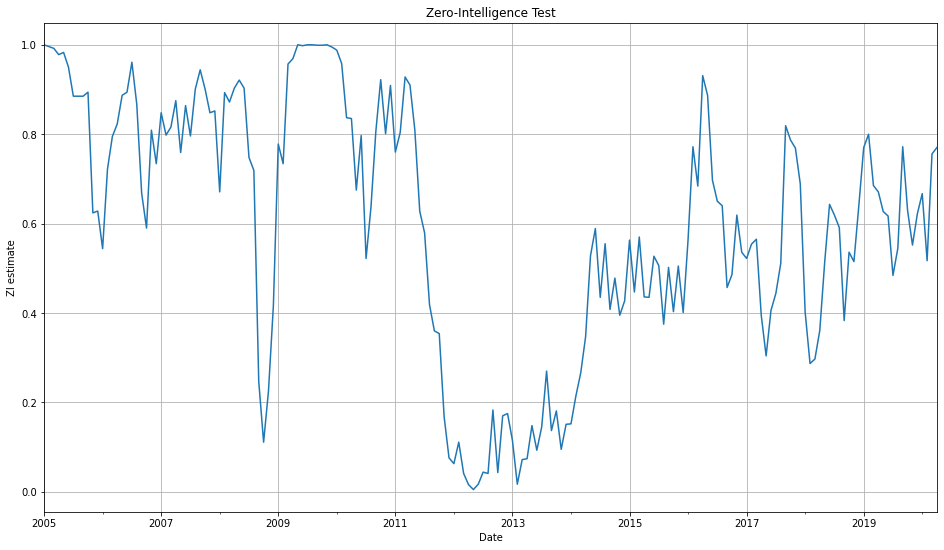

In [21]:
zi_est.plot()

plt.title("Zero-Intelligence Test")
plt.xlabel("Date")
plt.ylabel("ZI estimate")
plt.grid();